## Imports and Constants

In [1]:
import sys
import os
import numpy as np
import pandas as pd
from enum import Enum
from PIL import Image, ImageFilter

In [2]:
""" -- Constants -- """

# the various folders to look for images
NEW_FOLDER = "images_new_to_system/"
GENERATION_FOLDER = "tagged_images/"
ORIGINALS_FOLDER = "originals_in_system/"
DECODE_INPUT = "decoding/to_check_ownership/"
DECODE_OUTPUT = "decoding/owner_labeled/"
# where our mappings are stored
MAPPINGS_FILE = "mapping.csv"
# the image extension to work wiht
EXTENSION = ".png"
# the maximum color value allowed
COLOR_MAX = 255
# the offset to the pixel color to mark a positive
COLOR_OFFSET = 10
# the column names
COL_IMG_NUM = "ImgNum"
COL_TAG_NUM = "TagNum"
COL_OWNER = "Owner"

In [3]:
""" -- Constants calculated from above -- """

# calculate the ranges we need to fit into
ALLOWED_COLOR_MIN = COLOR_OFFSET
ALLOWED_COLOR_MAX = COLOR_MAX - COLOR_OFFSET
ALLOWED_COLOR_RANGE = ALLOWED_COLOR_MAX - ALLOWED_COLOR_MIN

# a global variable to only load the csv once
# the mappings dataframe to store the tags to people for each image
global_mappings = None

In [4]:
""" -- ensuring the folders exist -- """

# all of our folders
for folder in [ NEW_FOLDER,
                GENERATION_FOLDER,
                ORIGINALS_FOLDER,
                DECODE_INPUT,
                DECODE_OUTPUT]:
    if not os.path.exists(folder):
        os.makedirs(folder)

# our mapping file
if not os.path.exists(MAPPINGS_FILE):
    with open(MAPPINGS_FILE, 'w') as map:
        map.write(f"{COL_OWNER},{COL_IMG_NUM},{COL_TAG_NUM}\n")

## Helper Functions

In [5]:
def get_mappings():
    """ singleton pattern to get the mappings csv or load it in if needed """
    global global_mappings
    if global_mappings is None:
        global_mappings = pd.read_csv(MAPPINGS_FILE)
    return global_mappings


def mappings_append(owner: str, img_num: str, tag_num: str) -> None:
    """ edits the global mappings dataframe to append the given data """
    global global_mappings
    data_vals = {COL_OWNER: owner, COL_IMG_NUM: int(img_num), COL_TAG_NUM: int(tag_num)}
    global_mappings = get_mappings().append(data_vals, ignore_index=True)
    # save the new mappings
    global_mappings.to_csv(MAPPINGS_FILE, index=False)


def mappings_remove(img_num: str) -> None:
    """ removes the given image from the mappings dataframe """
    global global_mappings
    mappings = get_mappings()
    not_matching_img = mappings[COL_IMG_NUM] != int(img_num)
    global_mappings = mappings[not_matching_img]
    global_mappings.to_csv(MAPPINGS_FILE, index=False)

In [4]:
def image_exists(folder: str, name: str) -> bool:
    """ check if an image exists in just our file system """
    if name[:-len(EXTENSION)] != EXTENSION:
        name += EXTENSION
    return name in os.listdir(folder)


def image_exists_both(folder: str, name: str) -> bool:
    """ check if an image exists both in our folder and in our database """
    if name[:-len(EXTENSION)] == EXTENSION:
        name_png = name
        name_num = name[:[-len(EXTENSION)]]
    else:
        name_png = name + EXTENSION
        name_num = name
    if name_png not in os.listdir(folder):
        return False
    if name_num not in get_mappings()[COL_IMG_NUM].apply(str):
        print("mappings")
        return False
    return True


def open_image(folder: str, name: str) -> np.ndarray:
    """ opens the image at the given location and returns a copy of its pixels as a numpy array """
    return np.asarray(Image.open(folder + name).convert("RGB")).copy()

In [7]:
def standardize_image(orig_img: np.ndarray) -> np.ndarray:
    """ Takes an image and ensures it's within the correct bounds for standardization """

    # get where it's currently at
    img_min = orig_img.min()
    img_max = orig_img.max()
    img_range = img_max - img_min

    # make a copy to modify
    img = orig_img.copy()
    
    # if the range larger than we allow, need to squish it
    if img_range > ALLOWED_COLOR_RANGE:
        img -= img_min # shift down to 0
        img = img * (ALLOWED_COLOR_RANGE / img_range) # scale it down to the right width
        img += ALLOWED_COLOR_MIN # shift it up to the right spot
        img = img.astype(np.uint8) # get rid of the decimals
    else:
        # small enough range, just make sure it's in bounds
        if img_min < ALLOWED_COLOR_MIN:
            img += (ALLOWED_COLOR_MIN - img_min)
        elif img_max > ALLOWED_COLOR_MAX:
            img -= (ALLOWED_COLOR_MAX - img_max)
        else:
            # should already be perfectly in bounds
            pass

    return img

In [8]:
def find_next_open_img() -> int:
    """ Goes through the originals folder and finds the next available spot """
    old_generated = os.listdir(ORIGINALS_FOLDER)

    next_open = None
    if len(old_generated) == 0:
        next_open = 1
    else:
        next_open = 1 + max(int(name[:-4]) for name in old_generated)

    return next_open


def get_next_tag(img_num: str, person_name: str) -> int:
    """
    searches the mappings file for the next available tag for a certain image,
    then claims that for this person
    """
    # load in the current values
    mappings = get_mappings()
    # find the next tag for that image
    matching_image = mappings[COL_IMG_NUM] == int(img_num)
    if not any(matching_image):
        next_tag = 1 # don't do 0, idk why it just seems boring
    else:
        next_tag = 1 + max(mappings[matching_image][COL_TAG_NUM])
    # add the ID paired with their name
    mappings_append(person_name, img_num, next_tag)
    return next_tag

In [9]:
def get_block_sizes(a: int, b: int, is_vertical: bool = None) -> (bool, (int, int), (int, int)):
    """
    given the two dimensions of an image, return the sizes of each block it should be split into
    if a value is passed for is_vertical, force the image to be that direction, otherwise calculate it
    """
    wide = max(a, b)
    high = min(a, b)
    vertical = (wide == a) if (is_vertical is None) else is_vertical
    h1 = high // 2
    h2 = high - h1
    w1_2 = wide // 3
    w3 = wide - w1_2 - w1_2
    return (vertical, (h1, h2), (w1_2, w3))

In [10]:
def gen_rand(high: int, wide: int, trit: int) -> np.ndarray:
    """
    generates a random grid with high*rows and wide*columns with a range of 2 x COLOR_RANGE.
    if the trit is 0, they are left between (-range, range)
    if the trit is 1, they are offset to between (offset - range, offset + range)
    if the trit is 2, they are offset to between (-offset - range, -offset + range)
    """
    # generate the base random grid from (-range, range)
    rand = np.random.rand(high, wide, 3) * (COLOR_RANGE * 2) - COLOR_RANGE
    # offset it as necessary
    if trit == 1:
        rand += COLOR_OFFSET
    elif trit == 2:
        rand -= COLOR_OFFSET
#     elif trit == 0
#         rand += 0
    elif trit != 0:
        raise ValueError("Trit must be 0, 1, or 2")
    return rand


def find_section_average(img: Image, orig_vertical: bool = None) -> (np.ndarray, bool):
    """
    given an image, find the averages for each section and return it in a (2, 3) numpy array
    if a value is passed for orig_vertical, force the image to be that direction, otherwise calculate it
    """
    # get the block sizes
    h, w, _ = img.shape
    vertical, (h_1, h_2), (w_1_2, w_3) = get_block_sizes(h, w, orig_vertical)

    # flip the image if its vertical
    if vertical:
        img = img.transpose(1, 0, 2)
    
    # to hold our values as we find them
    averages = np.zeros((2, 3))
    
    # the control blocks
    # zero / none
    averages[0, 0] = img[:h_1, :w_1_2, :].mean()
    # one / positive
    averages[0, 1] = img[:h_1, w_1_2:2*w_1_2, :].mean()
    # two / negative
    averages[0, 2] = img[:h_1, 2*w_1_2:, :].mean()
    
    # the encoded blocks
    # low
    averages[1, 0] = img[h_1:, :w_1_2, :].mean()
    # mid
    averages[1, 1] = img[h_1:, w_1_2:2*w_1_2, :].mean()
    # high
    averages[1, 2] = img[h_1:, 2*w_1_2:, :].mean()
    
    # convert it to integers
    return (averages.astype(int), vertical)

## Functions to Export

In [11]:
def standardize_images(print_mode: bool) -> None:
    """
    goes through our folder of new images and squishes the colors into the
    correct range for easier manipulating later
    """
    imgs_to_convert = os.listdir(NEW_FOLDER)

    if print_mode and len(imgs_to_convert) == 0:
        print("No new images to convert, make sure to put them in", NEW_FOLDER)

    for img_name in imgs_to_convert:
        if print_mode:
            print("Standardizing", img_name)

        # open it (in RBG mode)
        img = open_image(NEW_FOLDER, img_name)
        
        # standardize it to between our bounds
        bounded_img = standardize_image(img)

        # find the next number we can name it
        next_num = find_next_open_img()

        # save to our folder as our extension
        Image.fromarray(bounded_img).save(ORIGINALS_FOLDER + str(next_num) + EXTENSION)

        # delete the image from the new-images folder
        os.remove(NEW_FOLDER + img_name)

In [12]:
def tag_image(img_name: str, person_name: str) -> str:
    """ generates a newly tagged version of that image for the requested person """
    assert image_exists(ORIGINALS_FOLDER, img_name), "Image must exist in the file system"

    #get the next tag
    next_tag = get_next_tag(img_name, person_name)
    tag = Ternary(next_tag)
    
    # open the image
    img = open_image(ORIGINALS_FOLDER, img_name + EXTENSION)
    h, w, _ = img.shape
    
    # get the sizes of the blocks
    vertical, (h_1, h_2), (w_1_2, w_3) = get_block_sizes(h, w)
    
    # create the randomized blocks
    rand = np.zeros(((h_1+h_2, w_1_2+w_1_2+w_3, 3)))
    # the control blocks
    # zero / none
    rand[:h_1, :w_1_2, :] = gen_rand(h_1, w_1_2, 0)
    # one / positive
    rand[:h_1, w_1_2:2*w_1_2, :] = gen_rand(h_1, w_1_2, 1)
    # two / negative
    rand[:h_1, 2*w_1_2:, :] = gen_rand(h_1, w_3, 2)
    # the encoded blocks
    # low
    rand[h_1:, :w_1_2, :] = gen_rand(h_2, w_1_2, tag.low)
    # mid
    rand[h_1:, w_1_2:2*w_1_2, :] = gen_rand(h_2, w_1_2, tag.mid)
    # high
    rand[h_1:, 2*w_1_2:, :] = gen_rand(h_2, w_3, tag.high)
    # flip it if necessary
    if vertical:
        rand = rand.transpose(1, 0, 2)
    
    # blur them together
    # convert the format to use PIL's BoxBlur
    blur = Image.fromarray((rand + ALLOWED_COLOR_MIN).astype(np.uint8))
    rad = min(w,h) / 6
    blur = blur.filter( ImageFilter.BoxBlur(radius=rad) )
    
    # add the randomness to the image
    done = img + np.asarray(blur) - ALLOWED_COLOR_MIN
    
    # save the image
    tagged_image_name = person_name + "_" + img_name + EXTENSION
    Image.fromarray(done).save(GENERATION_FOLDER + tagged_image_name)
    
    # tell them where it is
    return tagged_image_name

In [13]:
def decode_images(print_mode: bool) -> None:
    """ goes through our decoder's input folder and figures out who took them all """
    mappings = get_mappings()

    decode_inputs = os.listdir(DECODE_INPUT)

    if print_mode and len(decode_inputs) == 0:
        print("No images to decode! Put them in the folder", DECODE_INPUT)
        return

    for input_name in decode_inputs:
        if print_mode:
            print("Decoding image", input_name)

        clean_input_name = input_name[input_name.rfind("_") +1 : ] if ("_" in input_name) else input_name

        img_tag = decode_image(input_name)

        where_img = ( mappings["ImgNum"] == int(clean_input_name[:-len(EXTENSION)]) )
        where_tag = ( mappings["TagNum"] == img_tag.value )
        owners = mappings[where_img & where_tag]["Owner"]
        assert len(owners) == 1, "Found the wrong number of image owners! Found: " + str(len(owners)) + " for img " + input_name + " and tag " + str(img_tag)
        found_owner = owners.values[0]

        if print_mode:
            print("Owner found to be", found_owner)

        # label the image
        user_name = input_name[:-(1 + len(clean_input_name))] # get the first, user-given part of the name
        new_name = user_name + "(Owner-" + found_owner + ")_" + clean_input_name
        os.rename(DECODE_INPUT + input_name, DECODE_OUTPUT + new_name)

In [14]:
def remove_image(img_num: str) -> None:
    """ removes the given image from our database, originals folder, and tagged folder """

    # first remove our tagged images
    all_tagged = os.listdir(GENERATION_FOLDER)
    def get_num(img_name):
        return img_name[img_name.rfind("_") +1 : -len(EXTENSION)]
    for image in all_tagged:
        if get_num(image) == img_num:
            os.remove(GENERATION_FOLDER + image)

    # remove from the database
    mappings_remove(img_num)

    # remove from our originals folder
    os.remove(ORIGINALS_FOLDER + img_num + EXTENSION)

## Normalizing images

The same as before

## Encoding images

Going to be extremely different from before

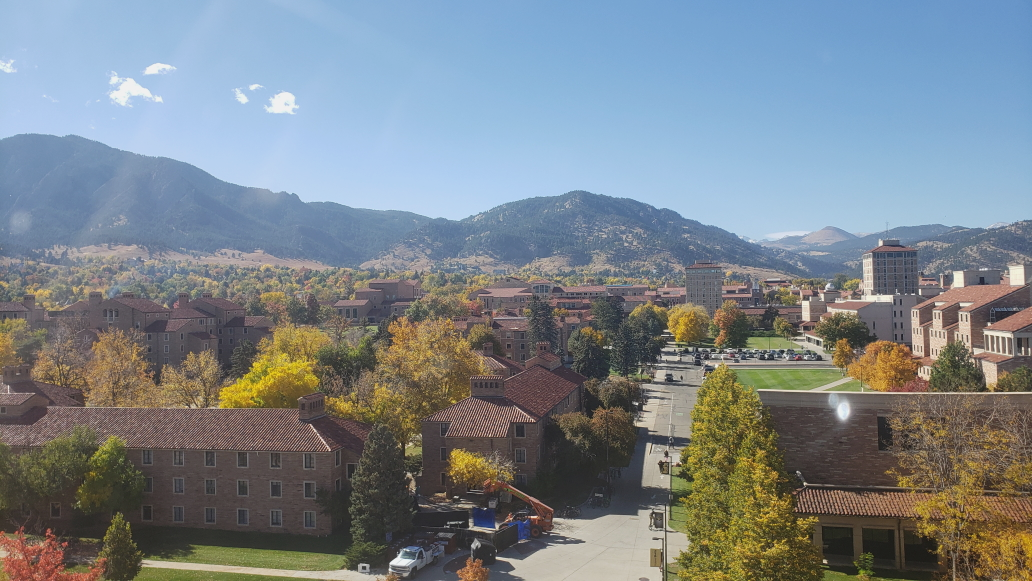

In [15]:
# get the image
img_name = "1.png"
img = open_image(ORIGINALS_FOLDER, img_name)
Image.fromarray(img)

In [16]:
# get the image size
h, w, _ = img.shape

In [6]:
# cut the size down by some designated padding, possibly a percentage
# assume they won't cut off more than 1/6th from any side
PADDING_PCT = 1/6

In [17]:
remaining_pct = 1 - PADDING_PCT - PADDING_PCT
pad_h = int(h * remaining_pct)
pad_w = int(w * remaining_pct)
pad_h, pad_w

(387, 688)

In [18]:
# get the name we want to log this under
name = "Jacob donald Swartwout"
# make it lowercase and replace spaces with underscores
name = name.lower().replace(" ", "_")
# ensure it's just letters and underscores
assert all(let == "_" or let.isalpha() for let in name), "name has something other than a letter or underscore"
name

'jacob_donald_swartwout'

In [19]:
# figure out the length of the name and ensure it's short enough
name_len = len(name)
# must be less than or equal to 27 so we can encode it into ternary ()
assert name_len <= 27, "Name is too long! " + str(name_len) + " letters is greater than our limit of 27!"
# each letter is 3 spots
num_spots = name_len * 3
name_len, num_spots

(22, 66)

In [5]:
# figure out the minimum size of squares to fit the name
def get_box_dims(h: int, w: int, leng: int) -> (int, int, int):
    """
    given a box with a known width and height, determine the rows and columns
    needed to be able to fit <leng> squares in with them being as large as possible,
    as well as the extra padding squares left
    """
    
    # know that a max for the size is going to be fitting them all exactly in
    size = int(np.sqrt(h * w / leng)) + 1
    # the count of boxes we have
    count = 0
    
    while count <= leng and size > 0:
        size -= 1
        rows = h // size
        cols = w // size
        count = rows * cols
    
    return (rows, cols, count - leng)
    
rows, cols, box_padding = get_box_dims(pad_h, pad_w, num_spots)
rows, cols, box_padding

NameError: name 'pad_h' is not defined

In [93]:
class Ternary:
    """ basic functionality to store a ternary value 3 trits long """
    def __init__(self, arg):
        if type(arg) is int:
            self.init_from_int(arg)
        elif type(arg) is tuple:
            self.init_from_trits(*arg)
        elif type(arg) is list:
            self.init_from_list(arg)
        elif type(arg) is str and len(arg) is 1:
            self.init_from_char(arg)
        else:
            raise TypeError("Unrecognized Ternary input, takes int, tuple, or list")
    
    def init_from_int(self, value):
        self.value = value
        self.low, self.mid, self.high = Ternary.int2tern(value)
        self.char = None
    
    def init_from_trits(self, high, mid, low):
        self.high = high
        self.mid = mid
        self.low = low
        self.value = Ternary.tern2int(high, mid, low)
        self.char = None
        
    def init_from_list(self, lst):
        self.high = lst[0]
        self.mid = lst[1]
        self.low = lst[2]
        self.value = Ternary.tern2int(lst[0], lst[1], lst[2])
        self.char = None
        
    def init_from_char(self, char):
        # just convert into a value
        if char.islower():
            self.char = char
            self.init_from_int(ord(char) - 96) # 97 = ord('a')
        elif char.isupper():
            self.char = char.lower()
            self.init_from_int(ord(char) - 64) # 65 = ord('A')
        elif char == " " or char == "_":
            self.char = "_"
            self.init_from_int(0) # [1-26]=>[a-z], [0]=>['_']
        else:
            raise ValueError("Unsupported character: " + char)
    
    def int2tern(val):
        low = val % 3
        val = val // 3
        mid = val % 3
        val = val // 3
        high = val % 3
        return low, mid, high
        
    def tern2int(high, mid, low):
        return 9*high + 3*mid + low
    
    def as_list(self):
        return [self.high, self.mid, self.low]
    
    def as_char(self):
        if self.value == 0:
            self.char = "_"
        else:
            self.char = chr(self.value + 96)
        return self.char
    
    def __str__(self):
        if self.char:
            return f"{self.char} (0t{self.high}{self.mid}{self.low})"
        else:
            return f"{self.value} (0t{self.high}{self.mid}{self.low})"
    

In [22]:
# convert the letters into ternary
tern_letters = [Ternary(let) for let in name]
[str(val) for val in tern_letters]

['j (0t101)',
 'a (0t001)',
 'c (0t010)',
 'o (0t120)',
 'b (0t002)',
 '_ (0t000)',
 'd (0t011)',
 'o (0t120)',
 'n (0t112)',
 'a (0t001)',
 'l (0t110)',
 'd (0t011)',
 '_ (0t000)',
 's (0t201)',
 'w (0t212)',
 'a (0t001)',
 'r (0t200)',
 't (0t202)',
 'w (0t212)',
 'o (0t120)',
 'u (0t210)',
 't (0t202)']

In [23]:
# convert them into a long string of trits
trit_name = [trit for let in tern_letters for trit in let.as_list()]
print(trit_name)

[1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 2, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 1, 2, 0, 1, 1, 2, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 2, 0, 1, 2, 1, 2, 0, 0, 1, 2, 0, 0, 2, 0, 2, 2, 1, 2, 1, 2, 0, 2, 1, 0, 2, 0, 2]


In [24]:
# append our padding to the end
ternary_data = trit_name + [0]*box_padding
print(ternary_data)

[1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 2, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 1, 2, 0, 1, 1, 2, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 2, 0, 1, 2, 1, 2, 0, 0, 1, 2, 0, 0, 2, 0, 2, 2, 1, 2, 1, 2, 0, 2, 1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0]


In [25]:
# going to make the offset matrix
# make it a numpy array
offsets = np.array(ternary_data)
# reshape it into our dimensions
offsets = offsets.reshape(rows, cols)
# some math to make 2's into -1's
offsets = (offsets + 1) % 3 - 1
# multiply by offset
offsets *= COLOR_OFFSET
offsets

array([[ 10,   0,  10,   0,   0,  10,   0,  10,   0,  10, -10,   0],
       [  0,   0, -10,   0,   0,   0,   0,  10,  10,  10, -10,   0],
       [ 10,  10, -10,   0,   0,  10,  10,  10,   0,   0,  10,  10],
       [  0,   0,   0, -10,   0,  10, -10,  10, -10,   0,   0,  10],
       [-10,   0,   0, -10,   0, -10, -10,  10, -10,  10, -10,   0],
       [-10,  10,   0, -10,   0, -10,   0,   0,   0,   0,   0,   0]],
      dtype=int32)

In [26]:
# repeat it so we have 3 color channels
offsets_3d = np.repeat(offsets[:, :, np.newaxis], 3, axis=2)
offsets_3d.shape

(6, 12, 3)

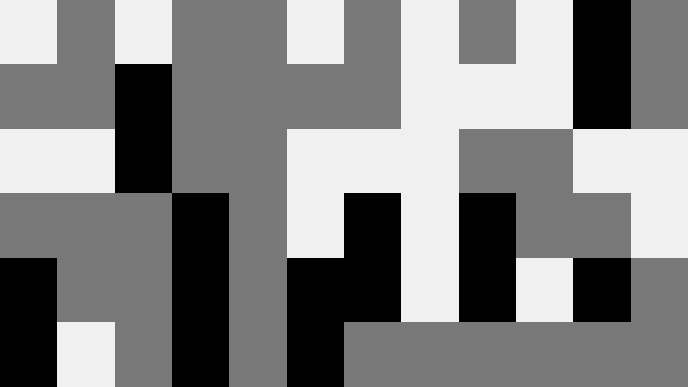

In [27]:
# convert the array into an image so we can scale up and blur it
# add so there's no negatives
in_range = offsets_3d + COLOR_OFFSET
# convert it to an image
as_img = Image.fromarray(in_range.astype(np.uint8))
# resize it
resized = as_img.resize((pad_w, pad_h), resample=Image.NEAREST)
# resized = as_img.resize((sub_w, sub_h), resample=Image.HAMMING) # can't do this since need to blur outside bounds too
Image.fromarray(np.array(resized)*(255 // (COLOR_OFFSET * 2)))

In [28]:
# can check the averages of each block (function is defined after this, in decoding section)
# sect_avgs = avg_blocks(np.array(resized), rows, cols)
# sect_avgs

In [29]:
# convert back to an array
offset_resized = np.array(resized)
offset_resized.shape

(387, 688, 3)

In [30]:
# figure out the width of the padding itself
top_pad = (h - pad_h) // 2
left_pad = (w - pad_w) // 2
top_pad, left_pad

(97, 172)

In [31]:
# make the string of values
control_data = [0, 1, 2] + Ternary(name_len).as_list()
control_data

[0, 1, 2, 2, 1, 1]

In [35]:
# make our arrays to store these values
# have it as long as the padding, then split into 6 sections
across = np.array_split(np.zeros(pad_w), 6)
# and as tall as padding, split into 6 again
up = np.array_split(np.zeros(pad_h), 6)
len(up), up[0].shape

(6, (65,))

In [36]:
# fill each block with the right data
for i in range(6):
    across[i] += control_data[i]
    up[i] += control_data[i]

In [39]:
# concatenate them all back together and format the values (2 => -1, and then on scale of offset)
control_across = ((np.concatenate(across) + 1) % 3 ) * COLOR_OFFSET
# repeat this line in both the vertical direction and the color direction
control_top = np.repeat(np.repeat(control_across[np.newaxis, :], repeats=(top_pad), axis=0)[:, :, np.newaxis], repeats=3, axis=2)
control_bottom = np.repeat(np.repeat(control_across[np.newaxis, :], repeats=(h - top_pad - pad_h), axis=0)[:, :, np.newaxis], repeats=3, axis=2)
print(control_top.shape)
control_top[0, ::10, 0] # the first row, every 10th item, just one color (just to check)

(97, 688, 3)


array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 20.])

In [40]:
# concatenate them all back together and format the values (2 => -1, and then on scale of offset)
control_up = ((np.concatenate(up) + 1) % 3 ) * COLOR_OFFSET
# repeat this line in both the horizontal direction and the color direction
control_left = np.repeat(np.repeat(control_up[:, np.newaxis], repeats=(left_pad), axis=1)[:, :, np.newaxis], repeats=3, axis=2)
control_right = np.repeat(np.repeat(control_up[:, np.newaxis], repeats=(w - left_pad - pad_w), axis=1)[:, :, np.newaxis], repeats=3, axis=2)
print(control_left.shape)
control_left[::10, 0, 0] # the first col, every 10th item, just to check

(387, 172, 3)


array([10., 10., 10., 10., 10., 10., 10., 20., 20., 20., 20., 20., 20.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.])

In [42]:
# the base image should be 0 change, but right now we're shifted up by COLOR_OFFSET
mask = np.zeros(img.shape, dtype=np.uint8) + COLOR_OFFSET

In [43]:
# add in our border around it now
mask[top_pad:top_pad+pad_h, 0:left_pad, :] = control_left
mask[top_pad:top_pad+pad_h, left_pad+pad_w:, :] = control_right
mask[0:top_pad, left_pad:left_pad+pad_w, :] = control_top
mask[top_pad+pad_h:, left_pad:left_pad+pad_w, :] = control_bottom

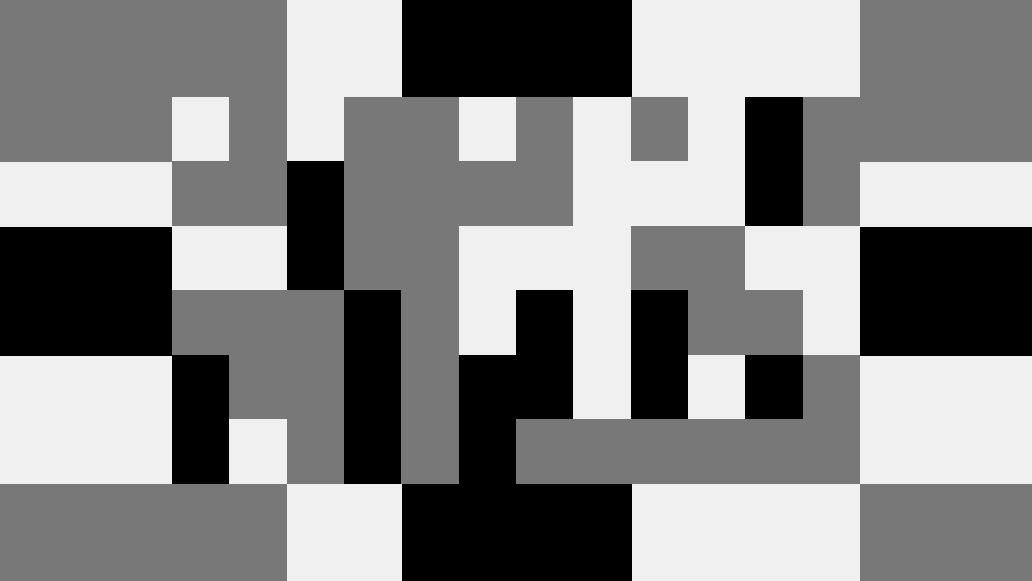

In [44]:
# put our offsets into the middle
mask[top_pad:top_pad+pad_h, left_pad:left_pad+pad_w, :] = offset_resized
Image.fromarray(mask * (255 // mask.max()))

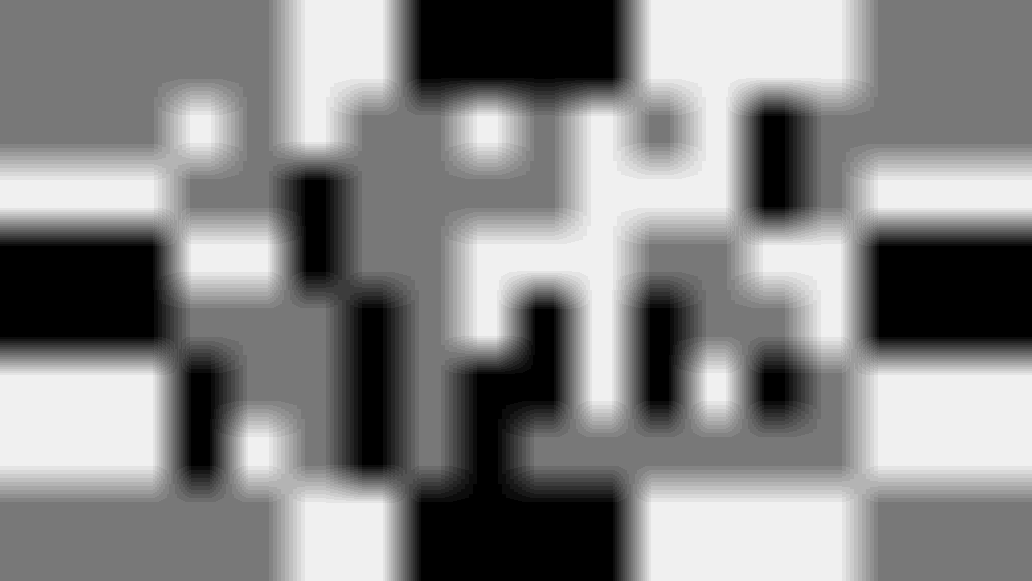

In [45]:
# blur our mask
blurred_mask = np.array(Image.fromarray(mask).filter(ImageFilter.BoxBlur(20))) # (box) size is 57
Image.fromarray(blurred_mask * (255 // blurred_mask.max()))

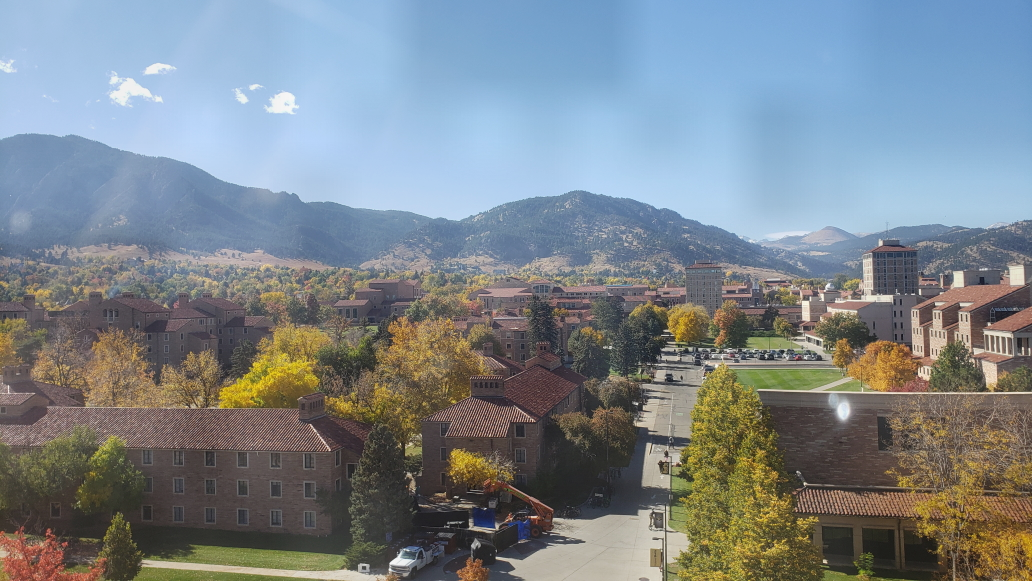

In [46]:
# add it to our image, re-subtracting COLOR_OFFSET
out_img = (img.copy().astype(int) + blurred_mask - COLOR_OFFSET).astype(np.uint8)
Image.fromarray(out_img)

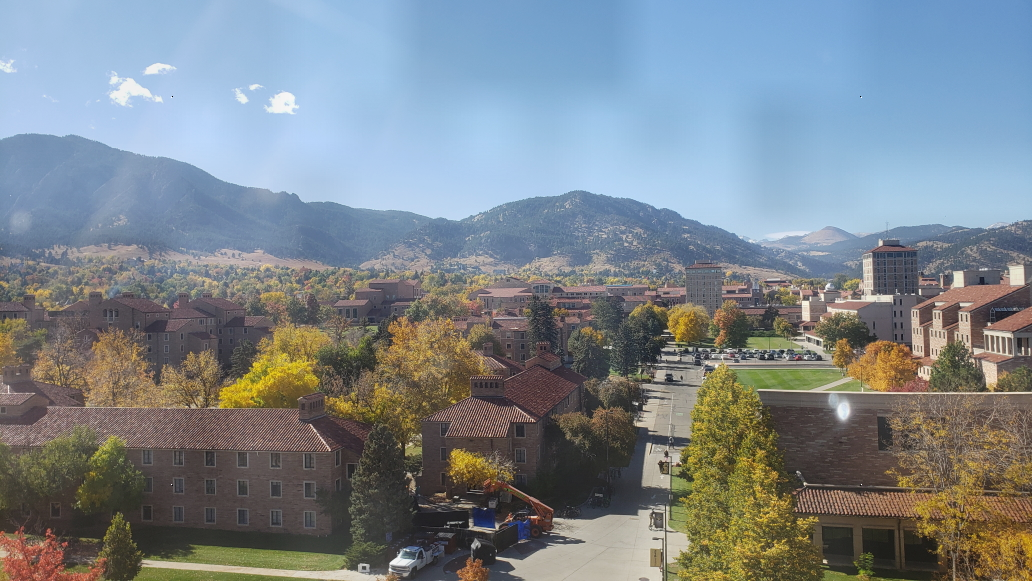

In [47]:
# mark the corners with a single pure white pixel on the horizontal outside of the bounds
for i in [-1, 1]:
    for j in [-1, 1]:
        out_img[i * top_pad, j*(left_pad-1)] = 255
# mark the corners with a single pure black pixel on the vertical outside of the bounds
for i in [-1, 1]:
    for j in [-1, 1]:
        out_img[i * (top_pad-1), j*left_pad] = 0

    # maybe put this step in the standardize

Image.fromarray(out_img)

In [48]:
# convert back to an image and save it
tagged_image_name = name + "-" + img_name
Image.fromarray(out_img).save(GENERATION_FOLDER + tagged_image_name)

# tell them where it is
tagged_image_name

'jacob_donald_swartwout-1.png'

## Decoding images

In [ ]:
"""
align the found image up with the real image as best as possible
calculate where the borders are
get the control values and the name length
use the name length to get the number of boxes we used
split the image into those boxes
average them
turn them back into trits using the control values (control averaged over all edges too)
break this into name_len blocks again
turn this into ternary letters
turn it into a string
""";

In [20]:
decode_list = os.listdir(DECODE_INPUT)
# for to_decode in decode_list:
wild_name = "crop-1.png"
wild_name

'crop-1.png'

In [22]:
wild_img = open_image(DECODE_INPUT, wild_name)
wild_h, wild_w, _ = wild_img.shape
wild_h, wild_w

(502, 885)

In [23]:
# find the black and white pixel corner markers (darkest pixels)
def pop_extreme(img: np.ndarray, do_mimumum: bool = True) -> (int, int, int):
    """ find the location of the minimum/maximum value in the array and set it to 127 """
    # find the lowest
    ndx = img.argmin() if do_mimumum else img.argmax()
    # convert it to a multi-dimensional tuple
    r, c, _ = np.unravel_index(ndx, img.shape)
    # "pop" it out in all 3 color dimensions
    img[r, c, :] = img[r-1, c-1, :]
    
    return (r, c)

In [24]:
corners = np.array([pop_extreme(wild_img, mnmx) for _ in range(4) for mnmx in [True, False]])
corners

array([[ 26,  52],
       [ 27,  51],
       [ 26, 740],
       [ 27, 741],
       [415,  52],
       [414,  51],
       [415, 740],
       [414, 741]], dtype=int64)

In [25]:
# find the actual corners

# get the mean to find the "center"
g_centers = corners.mean(axis=0)
# split things into above or below the center
g_greater_cent = corners > g_centers
# get the median of our samples (to avoid outliers)
g_top_ndx = int(np.median(corners[:, 0][~g_greater_cent[:, 0]]) + .5)# where the y's are not below center
g_bottom_ndx = int(np.median(corners[:, 0][g_greater_cent[:, 0]]) - .5) # where the y's are below center
g_right_ndx = int(np.median(corners[:, 1][g_greater_cent[:, 1]]) - .5) # where the x's are righter than center
g_left_ndx = int(np.median(corners[:, 1][~g_greater_cent[:, 1]]) + .5) # where the x's are not righter than center
(g_left_ndx, g_right_ndx), (g_top_ndx, g_bottom_ndx)

((52, 740), (27, 414))

In [26]:
# test, can see that without rescaling the corners are where we expect
(left_pad, left_pad + pad_w), (top_pad, top_pad + pad_h)

NameError: name 'left_pad' is not defined

In [27]:
# start loading in the original version of this image
lab_name = wild_name[wild_name.rfind("-")+1:]
print(lab_name)
lab_img = open_image(ORIGINALS_FOLDER, lab_name)
lab_img.shape

1.png


(581, 1032, 3)

In [28]:
# calculate the original shape
lab_h, lab_w, _ = lab_img.shape
# get the padding
remaining_pct = 1 - PADDING_PCT - PADDING_PCT
lab_pad_h = int(lab_h * remaining_pct)
lab_pad_w = int(lab_w * remaining_pct)
lab_pad_h, lab_pad_w

(387, 688)

In [29]:
# get the wild size
wild_pad_h = g_bottom_ndx - g_top_ndx
wild_pad_w = g_right_ndx - g_left_ndx
wild_pad_h, wild_pad_w

(387, 688)

In [30]:
# can now figure out how to crop and scale the lab image
lab_new_h = int(lab_h * (wild_pad_h / lab_pad_h))
lab_new_w = int(lab_w * (wild_pad_w / lab_pad_w))
lab_new_h, lab_new_w

(581, 1032)

(581, 1032, 3)


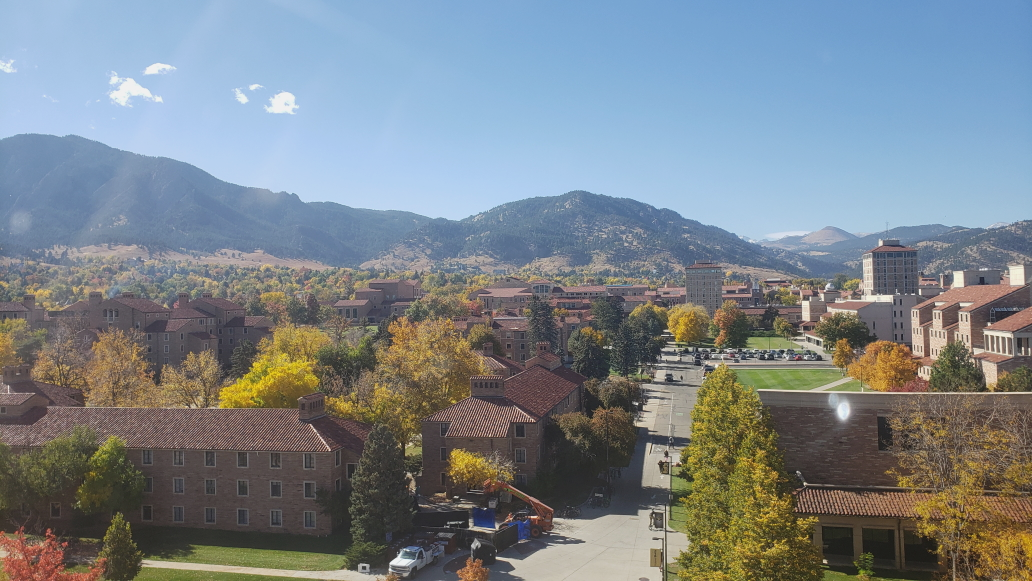

In [31]:
# resize it
lab_resized = np.array(Image.fromarray(lab_img).resize((lab_new_w, lab_new_h)))
print(lab_resized.shape)
Image.fromarray(lab_resized)

In [32]:
# figure out the width of the padding itself
lab_top_pad = (lab_h - lab_pad_h) // 2
lab_left_pad = (lab_w - lab_pad_w) // 2
lab_top_pad, lab_left_pad

(97, 172)

##  WORKING HERE

In [36]:
top_cut = lab_top_pad - g_top_ndx
left_cut = lab_left_pad - g_left_ndx
top_cut, left_cut

(70, 120)

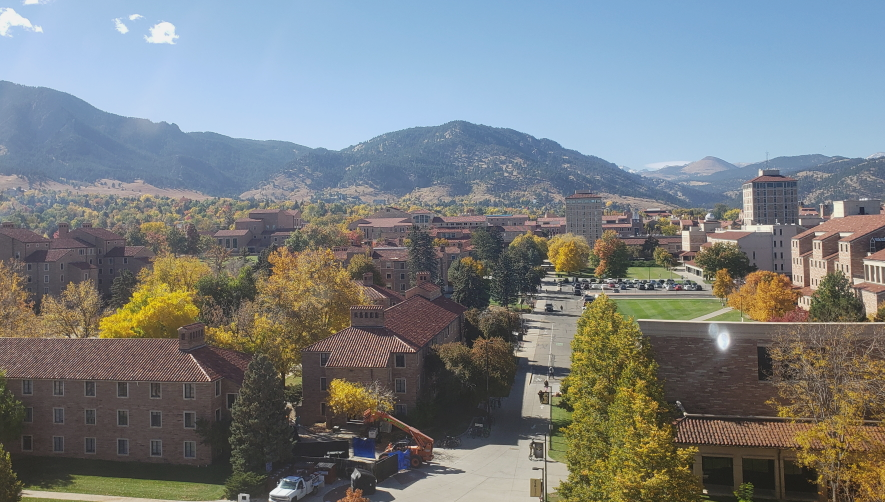

In [37]:
lab_crop = lab_resized[top_cut : top_cut+wild_h, left_cut : left_cut+wild_w]
Image.fromarray(lab_crop)

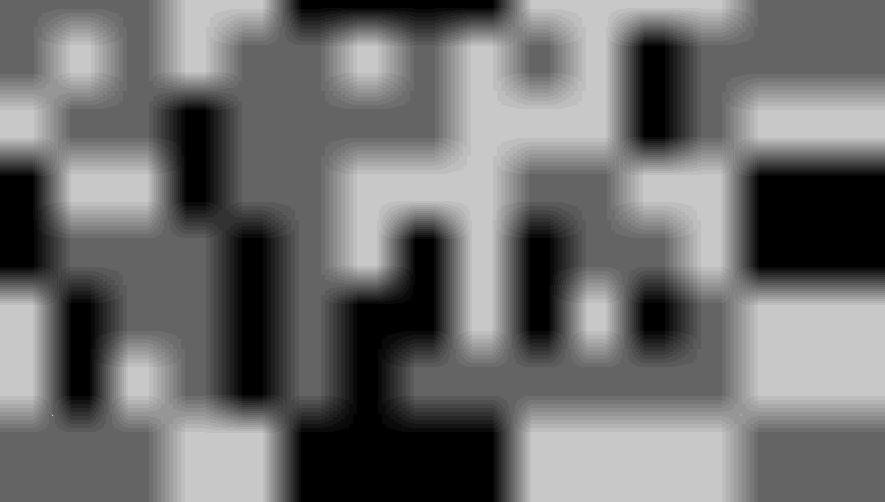

In [42]:
# subtract the two to get the data
found_mask = wild_img.astype(float) - lab_crop.astype(float)

# for printing only
to_show = found_mask.copy()
to_show -= to_show.min()
to_show *= 10
Image.fromarray(to_show.astype(np.uint8))

In [43]:
Image.fromarray(blurred_mask * 10)

NameError: name 'blurred_mask' is not defined

In [55]:
(g_top_ndx, g_bottom_ndx), (g_left_ndx, g_right_ndx)

((27, 414), (52, 740))

In [75]:
# grab the borders
def mean_edge(horiz_edge: np.ndarray):
    boxes = np.array_split(horiz_edge, 6, axis=1)
    return [(box.size, box.mean()) for box in boxes]


left_means = mean_edge(found_mask[g_top_ndx:g_bottom_ndx,  :g_left_ndx].transpose(1, 0, 2))
right_means = mean_edge(found_mask[g_top_ndx:g_bottom_ndx, g_right_ndx: ].transpose(1, 0, 2))
top_means = mean_edge(found_mask[ :g_top_ndx, g_left_ndx:g_right_ndx])
bottom_means = mean_edge(found_mask[g_bottom_ndx: , g_left_ndx:g_right_ndx])

edge_means = [left_means, right_means, top_means, bottom_means]

for lst in edge_means:
    print([area[0] for area in lst])
    print([area[1] for area in lst])
    print()

[10140, 10140, 10140, 9984, 9984, 9984]
[1.513905325443787, 7.093491124260355, -6.831952662721894, -7.6484375, 6.727163461538462, 7.447716346153846]

[28275, 28275, 28275, 27840, 27840, 27840]
[0.7681697612732096, 7.452944297082228, -7.847002652519894, -7.829202586206897, 8.16864224137931, 8.926939655172413]

[9315, 9315, 9315, 9315, 9234, 9234]
[1.2726784755770264, 7.928502415458937, -6.573268921095008, -6.47987117552335, 8.277452891487979, 6.985055230669266]

[30360, 30360, 30360, 30360, 30096, 30096]
[0.46001317523056656, 7.9598814229249015, -8.897628458498025, -8.63300395256917, 8.605063795853269, 9.042264752791068]



In [77]:
# merge them together
master_edge = []
for i in range(6):
    total = sum(edge[i][0] * edge[i][1] for edge in edge_means)
    count = sum(edge[i][0] for edge in edge_means)
    master_edge.append(total / count)
    
controls = master_edge[:3]

master_edge

[0.8053784095274683,
 7.660084517864003,
 -7.971724932769881,
 -7.958618820888011,
 8.165370557586126,
 8.548098607978847]

In [98]:
# decode the length of the string now
wild_name_len = Ternary([np.argmin([abs(test-cont) for cont in controls]) for test in master_edge[3:]]).value
wild_name_len

22

In [109]:
# get the rows and columns
# do this on the lab image so the integer math works out the same
wild_rows, wild_cols, wild_padding = get_box_dims(lab_pad_h, lab_pad_w, wild_name_len * 3)
wild_rows, wild_cols, wild_padding

(6, 12, 6)

(387, 688)


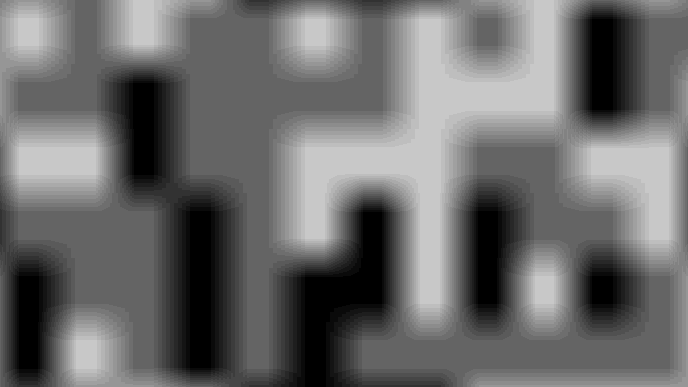

In [128]:
# pull out the actual data cells now and flatten it
center_data = found_mask[g_top_ndx:g_bottom_ndx, g_left_ndx:g_right_ndx].mean(axis=2)
print(center_data.shape)
Image.fromarray(((center_data + 10) * 10).astype(np.uint8))

In [129]:
# split it into a grid
found_cells = [np.array_split(row, wild_cols, axis=1) for row in np.array_split(center_data, wild_rows, axis=0)]
len(found_cells), len(found_cells[0]), found_cells[0][0].shape

(6, 12, (65, 58))

In [125]:
rows, cols, (lab_pad_h // rows, lab_pad_w // cols)

NameError: name 'rows' is not defined

In [140]:
# average them and make them a single list
found_data = [cell.mean() for row in found_cells for cell in row]

print(["%.2f" % num for num in found_data])

['6.92', '1.45', '6.86', '1.13', '0.22', '6.12', '0.79', '7.12', '2.96', '7.54', '-6.18', '-0.04', '2.01', '0.00', '-6.98', '-0.59', '0.15', '1.37', '1.86', '9.22', '8.63', '7.42', '-6.11', '0.66', '6.92', '6.72', '-6.87', '-1.39', '0.93', '8.45', '7.83', '8.84', '0.66', '1.30', '7.25', '7.60', '-0.86', '0.45', '-1.44', '-7.70', '0.27', '5.88', '-5.52', '6.79', '-6.85', '-0.06', '0.69', '6.77', '-6.80', '-0.01', '-0.97', '-8.17', '-1.53', '-8.04', '-7.15', '6.08', '-6.00', '5.42', '-6.30', '0.58', '-5.95', '6.40', '0.44', '-6.90', '-2.22', '-8.44', '-1.94', '-0.17', '0.19', '1.24', '0.25', '1.47']


In [145]:
# find the closest tag for each
wild_tag = [abs(controls - sample).argmin() for sample in found_data][:wild_name_len*3]
print(wild_tag)

[1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 2, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 1, 2, 0, 1, 1, 2, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 2, 0, 1, 2, 1, 2, 0, 0, 1, 2, 0, 0, 2, 0, 2, 2, 1, 2, 1, 2, 0, 2, 1, 0, 2, 0, 2]


In [149]:
# split it into 3s
name_chars = [Ternary(wild_tag[3*i:3*i +3]).as_char() for i in range(wild_name_len)]
print(name_chars)

['j', 'a', 'c', 'o', 'b', '_', 'd', 'o', 'n', 'a', 'l', 'd', '_', 's', 'w', 'a', 'r', 't', 'w', 'o', 'u', 't']


In [150]:
# convert back into a word
found_name = "".join(name_chars)
found_name

'jacob_donald_swartwout'

In [176]:
# rename it now
print(wild_name, lab_name)
new_name = f"({found_name}){wild_name}"
new_name

crop-1.png 1.png


'(jacob_donald_swartwout)crop-1.png'

In [177]:
os.rename(DECODE_INPUT + wild_name, DECODE_OUTPUT + new_name)

In [ ]:
# crop and then resize the original image to the same size
# subtract the two pictures to get the changes
# get the borders
    # .array_split(6)
# group and average all of the things which should be the same
    # (.reshape((1,)) + .reshape((1,)) + ... ).mean()
# separate out the controls to use as reference points
# convert the other controls into trits
# convert it to get the length
# calculate the number of blocks, using the original image size since it's kinda based on integer math
# break the image into blocks
# convert each block into a trit based on the controls (up to name_len number of them)
# break the list up into Ternary values by groups of 3
# convert the ternary values into letters
# turn this back into a string

## Deleting Images

In [ ]:
# there's just no database now

## Menu stuff

In [ ]:
# run to standardize
# standardize_images(print_mode: bool) -> None
standardize_images(True)

In [ ]:
# run to encode
# tag_image(img_name: str, person_name: str) -> str

In [ ]:
# run to decode
# decode_images(print_mode: bool) -> None

In [ ]:
# run to delete
# remove_image(img_num: str) -> None